# Toy MC for the ATLAS High Granularity Timing Detector

<ul>

<li>This program is a toy Monte Carlo used to simulate noise and signal on the ATLAS High Granularity Detector, and study the uncertainties in the luminosity that can be achieve with the help of this detector.</li>
<li>Written by Ruben Pozzi for the KTH ATLAS Group</li>
<li>Supervisor: Christian Ohm - christian.ohm@cern.ch</li>
<li>Contact: rubenp@kth.se, rubenpozzi97@gmail.com</li>
</ul>

### Import stuff

In [51]:
import ROOT
from ROOT import TCanvas, TGraph, gROOT
import numpy as np
import time
import matplotlib.pyplot as plt
import time 
from array import array
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator

### Constants

In [52]:
nr_of_channels = int(3.6 * 1e6) #number of channels on the HGTD
channels_per_module = int(15*30) #number of channels in each module of the detector
total_modules = int(nr_of_channels/channels_per_module) #number of modules
global_counter = 0 #global counter used for the pseudorandomgenerator in the next section

### Noise Generator Class:
<ul>
<li>This class takes in the parameters threshold and channel count (proportional to the number of interactions $\mu$ per bunch crossing) and calculates the mean number of channels activated by noise <code>mean</code> by calculating the probability mass that a part of the Gaussian distribution will be above the set threshold, and multiplies it with the total number of channels.</li>
<li>The class has a function generate, which calculates a variation of the mean number of noise activated channels by drawing from a Poisson distribution with <code>mean</code> as parameter, and calculates how many of them are triggered during the small time window of $3.125ns$ (the <i>true</i> value, <code>narrow_exact</code>) by drawing from a uniform distribution $(0,1)$ for each number of noise activated channel and seeing how many are in the small time window. For example, with a large window of 25ns, it would check how many values drawn from the uniform distribution are lower than 0.125 {=3.125/25 = 0.125}. </li>
<li>Finally, it <i>estimates</i> the number of triggered channels in the small window <code>estimate</code> by determining the number of channels triggered in one ns and multiplying by 3.125ns. This way, we have a <i>true</i> number of noise activated channels in the small window, and one that is <i>estimated</i>.</li>


</ul>
<b>Note:</b> try different big time windows , eg 4x3.125, lines 25-26. Change value of *big_window*

In [60]:
class noise_generator:

    def __init__(self, threshold, channel_count, large_window_factor): 
        global global_counter
        
        # Define the gaussian distribution function centered around 0 with std 5mV, limits 0 to 1000
        low = 0
        high = 1000      
        noise = ROOT.TF1("noise_gauss", "TMath::Gaus(x, 0, 5)", low, high)
        
        # Integrate normal dist. to get exact prob. above threshold and multiply with channel nr to get avg. number
        # of noise activated channels
        self._mean = channel_count * noise.Integral(threshold, high)/noise.Integral(low, high) 
        
        # Pseudorandom generator 
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)
        
        self._large_window_factor = large_window_factor

    def generate(self):
        
        """The first return value is the exact number of noise activated channels in the small window and
            the second return value is the estimated number of noise activated channels in the small window. (estimated from large window)
            (both results are in small window, both results are noise above threshold)
            noise_exact, noise_est = noise.generate()"""
        
        prng = self._prng
        # Sample a Poisson dist. around the mean value 
        total = prng.Poisson(self._mean) # number of noise above threshold in large window in this run.
        
        # Width of the large time window - multiple of the smaller one (N*3.125ns)
        big_window = self._large_window_factor*3.125#ns
        
        # Determine how many noise activated channels in the small time window 
        narrow_exact = 0 # Exact number of noise activated channels in the small window
        narrow_exact = (np.random.rand(total) < 3.125/big_window).sum() # ex. 3.125/(3.125*4) big window of 4 times 3.125 
        
        # Determine the unit of noise activated channels from the large time window 
        # and use it to estimate the number of noise act. channels in the smaller one
        noise_per_time = (total - narrow_exact)/(big_window - 3.125)  
        estimate = 3.125 * noise_per_time
        
        return narrow_exact, estimate

 ### Signal Generator Class:
<ul>

<li>This class takes the input parametes threshold and the real and guessed most probable peak voltage of the signal distribution (100mV when the sensors are new).</li>
<li>It calculates the fraction of the Landau distribution that will be above the set threshold <code>fraction_above</code>. It has a function <code>generate()</code>, which takes in the paramter <code>expected_count</code>, that is, the estimated number of particles that will reach the detector (for mu=200 it is around 15k), then it determines a simulated number of hits on the detector by drawing from a Poisson distribution around that parameter.</li>
<li>Finally, for each calculated hit, it determines how many channels were triggered by signal from a particle by sampling a Landau distribution and checking how many of them are above the threshold. It returns the number of particles hitting the detector, and the number of signal-activated channels.</li>
</ul>
 

In [61]:
class signal_generator:
    def __init__(self, threshold, real_expected_voltage, guess_expected_voltage): # expected_voltage = expected peak voltage  (mu)
        global global_counter
        
        # Define the signal function distribution (Landau) with the guessed mpv peak voltage between -100 and 1000
        low = -100
        high = 1000
        self._threshold = threshold
        self._expected_voltage = real_expected_voltage
        signal_func = ROOT.TF1("sth", "TMath::Landau(x, %f, %f)" % (guess_expected_voltage, guess_expected_voltage/4), low, high)
        
        # Determine the fraction of the function that is above threshold by integrating 
        self.fraction_above = signal_func.Integral(threshold, high)/signal_func.Integral(low, high) 
        
        global_counter += 1
        self._prng = ROOT.TRandom3(int(time.time()) + global_counter)
    
    def generate(self, expected_count):
        """The paramater is the expected number of particles that reach the detector.
            The first return value is the number of particles that reached the detector and
            the second return value is the number of activated channels.
            signal_real_total, signal_above = signal.generate(30)"""
        
        prng = self._prng
        expected_voltage = self._expected_voltage
        threshold = self._threshold
        # True number of signal activated channels 
        signal_count = prng.Poisson(expected_count)
        above_threshold_count = 0
        sigma = expected_voltage/4
        for i in range(signal_count):
            if prng.Landau(expected_voltage, sigma) > threshold: # 1/4 is just the refernce 25/100
                above_threshold_count += 1
        return signal_count, above_threshold_count
    

## Simulation function


In [62]:
def simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage):
    """For a number of BC, we get two lists: total_actual_signal_count and total_estimated_signal_count for each BC"""

    channel_count = nr_of_channels*ratio_of_channels_to_sample
    #avg_particles_reaching_detector = channel_count * signal_to_channel_count_ratio

    #generate the noise
    noise_gen = noise_generator(threshold, channel_count, large_window_factor)
    #generate the signal
    signal_gen = signal_generator(threshold, peak_mpv_voltage, guess_mpv_voltage)

    result_true_signal_count = np.zeros(bunch_crossings)
    result_estimated_signal_count = np.zeros(bunch_crossings)
    error_estimation = 0
    signal_fraction_above = signal_gen.fraction_above
    deviation_from_true = np.zeros(bunch_crossings)
    for BC in range(bunch_crossings):
        # both results are in small window, both are noise above threshold
        noise_exact, noise_est = noise_gen.generate()

        # The paramater is the expected number of particles that reach the detector.
        # The first return value is the number of particles that reached the detector and 
        # the second return value is the number of activated channels.
        total_actual_signal, signal_above = signal_gen.generate(expected_count)

        # from the total activations, estimate how much was produced by actual signal
        total_activations = signal_above + noise_exact  # total activations in small window (i.e. above threshold)
        #print("\nBunch Crossing %d:" %(BC+1))
        #print("Signal- and noise-activated channels: %d" %(total_activations))
        #print ("Noise-activated channels: %d" %(noise_exact))
        #total real activations minus estimation of signal, then divide with the prob. mass for Landau to be above threshold
        total_signal_est = (total_activations - noise_est)/signal_fraction_above 

        # assign the results
        result_true_signal_count[BC] = total_actual_signal #exact count in the small window
        result_estimated_signal_count[BC] = total_signal_est #estimated count 
        
        deviation_from_true[BC] = total_signal_est - total_actual_signal
        #deviation_from_true[BC] = deviation_from_true[BC]/ total_actual_signal
    return result_true_signal_count, result_estimated_signal_count, deviation_from_true

### Function to find best threshold

In [63]:
def find_best_threshold (total_deviation):
    """Input parameter is a list of the deviation for each threshold, returns the best threshold with lowest deviation"""
    
    total_deviation = [round(num, 6) for num in total_deviation]

    best_array_indexes = [i for i, x in enumerate(total_deviation) if x == min(total_deviation)]
    print("Size of array: %d" %len(best_array_indexes))
    best_thresholds_array = np.zeros(len(best_array_indexes))
    if len(best_array_indexes)==1:
         print("best threshold: %f" %(threshold_array[best_array_indexes[0]]))
         return threshold_array[best_array_indexes[0]]
    
    else: 
        for i in range (len(best_array_indexes)):
            best_thresholds_array[i] = threshold_array[best_array_indexes[i]]
        print (best_thresholds_array)
        return sum(best_thresholds_array)/len(best_thresholds_array)

### Parameters for the simulation

In [64]:
peak_mpv_voltage = 100 #mV, mpv: most probable value
guess_mpv_voltage = 100 #mV
mu = 0.01

large_window_factor = 4 #How many times the large window is bigger than the smaller one

"""exp number of particles on detector proportional to mu, try also non-linear relationship as in christian's plot """
expected_count = (15*1e3/200)*mu #expected number of particles reaching the HGTD for mu=200, no more than 20k
bunch_crossings = 1000
ratio_of_channels_to_sample = 0.5
print("Expected count: %f" %expected_count)

min_threshold = 10#mV
max_threshold = 95#mV
threshold_steps = 20

#Put same min and max, and step=1 to try only for a single mpv of peak voltage
min_mpv_peak = 100 #mV, the sensor at its worst state
max_mpv_peak = 100 #mV, new sensors
mpv_peak_steps = 1
guess_mpv_voltage_bias = 1 #percentage of bias of guessed mpv voltage

Expected count: 0.750000


## Computation

In [65]:
start_time = time.time()

mpv_peak_array = np.linspace(min_mpv_peak,max_mpv_peak,mpv_peak_steps)
threshold_array = np.linspace(min_threshold,max_threshold,threshold_steps)
best_threshold_array = np.zeros (len(mpv_peak_array))
min_deviation_array = np.zeros(len(mpv_peak_array))
mpv_and_deviation = np.zeros((len(threshold_array), len(mpv_peak_array)))

iteration_peak = 0

for peak_value_step in mpv_peak_array:
    print ("\n------------------------------------------------------------")
    print("Simulations for mpv peak voltage %dmV\n" %peak_value_step)

    iteration = 0
    total_deviation= np.zeros(len(threshold_array))
    mean_values = []
    mean_values_with_std = []
    std_values = []
    
    for threshold in threshold_array:
        true_signal, estimated_signal, dev_per_BC = simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_value_step, peak_value_step*guess_mpv_voltage_bias)
        """Get the total deviation from the total simulated signals vs the expected signals.
            Returns both the total deviation as a positive number"""
           
        true_signal_sum = true_signal.sum()
        if true_signal_sum == 0:
            deviation = 0
        deviation = abs( estimated_signal.sum() / true_signal_sum -1)
        total_deviation[iteration] = deviation
        #print("\nDeviation for threshold %f: %f" %(threshold, total_deviation[iteration]))
        
        mean_values.append(abs(np.mean(dev_per_BC)))
        mean_values_with_std.append(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
        print ("%.2f Threshold - Mean dev: %f" %(threshold, mean_values[iteration]))
        std_values.append(np.std(dev_per_BC))
        print ("                - Std: %f" %( std_values[iteration]))
            
        mpv_and_deviation[iteration][iteration_peak] = np.mean(abs(np.mean(dev_per_BC))+np.std(dev_per_BC))
        iteration = iteration+1
            
    best_threshold_array [iteration_peak] = find_best_threshold(mean_values)
    min_deviation_array [iteration_peak] = min(mean_values)
    print ("Best threshold for mpv peak voltage %dmV: %fmV" %(peak_value_step,best_threshold_array[iteration_peak]))
    print ("Minimum deviation for mpv peak voltage %d: %f" %(peak_value_step, min_deviation_array[iteration_peak]))
    print ("------------------------------------------------------------\n") 
    iteration_peak = iteration_peak+1
    
print("Computation done!\nCPU time: %s seconds" % (time.time() - start_time))



------------------------------------------------------------
Simulations for mpv peak voltage 100mV

10.00 Threshold - Mean dev: 4.756667
                - Std: 161.548703
14.47 Threshold - Mean dev: 3.691671
                - Std: 47.418661
18.95 Threshold - Mean dev: 0.710000
                - Std: 9.087761
23.42 Threshold - Mean dev: 0.025629
                - Std: 1.268710
27.89 Threshold - Mean dev: 0.004177
                - Std: 0.115910
32.37 Threshold - Mean dev: 0.000526
                - Std: 0.000592
36.84 Threshold - Mean dev: 0.001367
                - Std: 0.001490
41.32 Threshold - Mean dev: 0.000071
                - Std: 0.054825
45.79 Threshold - Mean dev: 0.002042
                - Std: 0.063492
50.26 Threshold - Mean dev: 0.001153
                - Std: 0.114642
54.74 Threshold - Mean dev: 0.000320
                - Std: 0.140948
59.21 Threshold - Mean dev: 0.003057
                - Std: 0.167762
63.68 Threshold - Mean dev: 0.006111
                - Std: 0.19139

 ### Graphical estimation of best threshold with regards to deviation from the true signal 
Use only with one mpv for the voltage

Size of array: 1
best threshold: 41.315789
Best threshold: 41
CPU time: 6.692488193511963 seconds


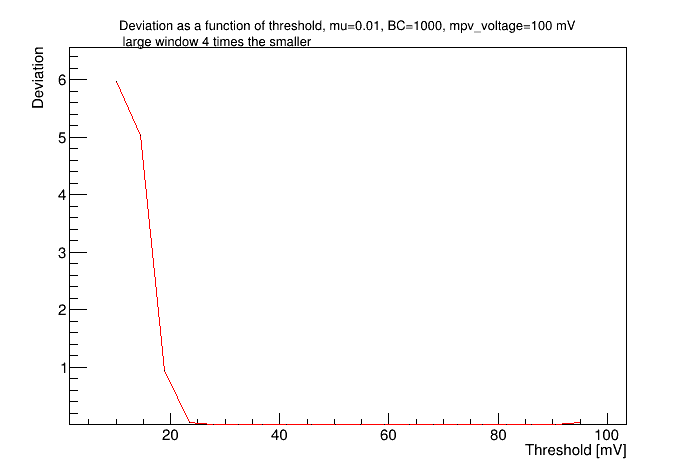

In [66]:
best = find_best_threshold(total_deviation)
print("Best threshold: %d"%best)

c1 = TCanvas( 'c1', 'Graph', 200, 10, 700, 500 )
#c1.SetLogy()

g = TGraph(len(threshold_array), threshold_array.astype(np.double),total_deviation.astype(np.double))
g.SetTitle( "#splitline{Deviation as a function of threshold, mu=%.2f, BC=%d, mpv_voltage=%d mV}{\n large window 4 times the smaller}"  %(mu, bunch_crossings, peak_mpv_voltage))
g.GetXaxis().SetTitle( 'Threshold [mV]' )
g.GetYaxis().SetTitle( 'Deviation' )
g.GetYaxis().SetRange(0,10);
g.SetLineColor(2)
g.Draw(); 
c1.Draw()
c1.Modified()
c1.Update();
print("CPU time: %s seconds" % (time.time() - start_time))

### Finer search for the best threshold: mean values and corresponding standard deviations

Warning in <TCanvas::Constructor>: Deleting canvas with same name: std over Threshold
Warning in <TCanvas::Constructor>: Deleting canvas with same name: mean canvas
Warning in <TCanvas::Constructor>: Deleting canvas with same name: mean_std


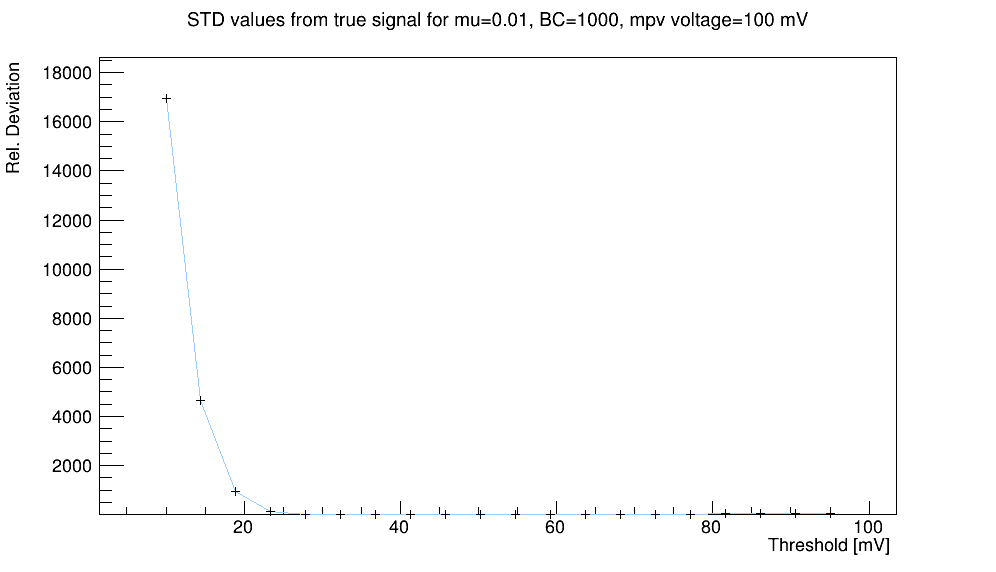

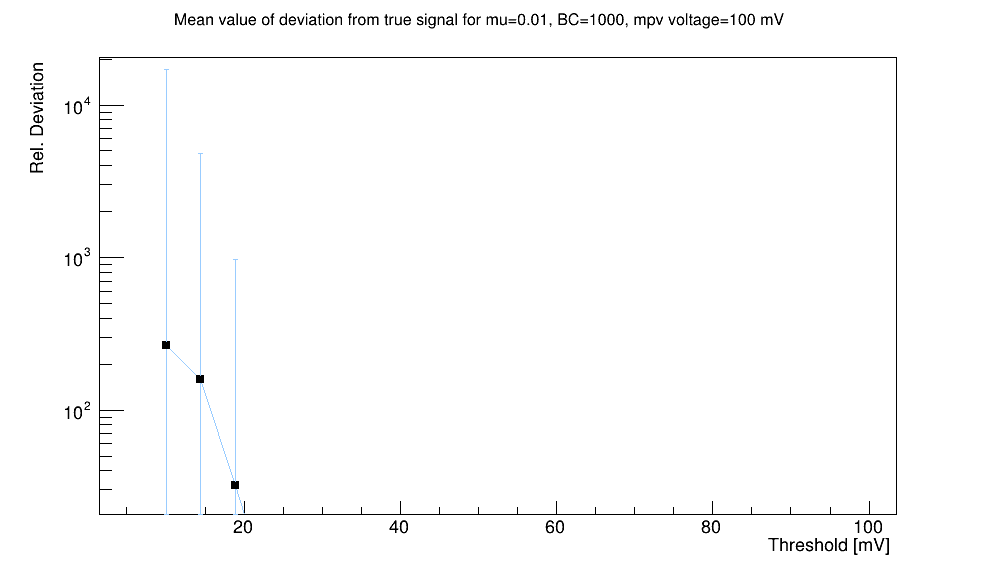

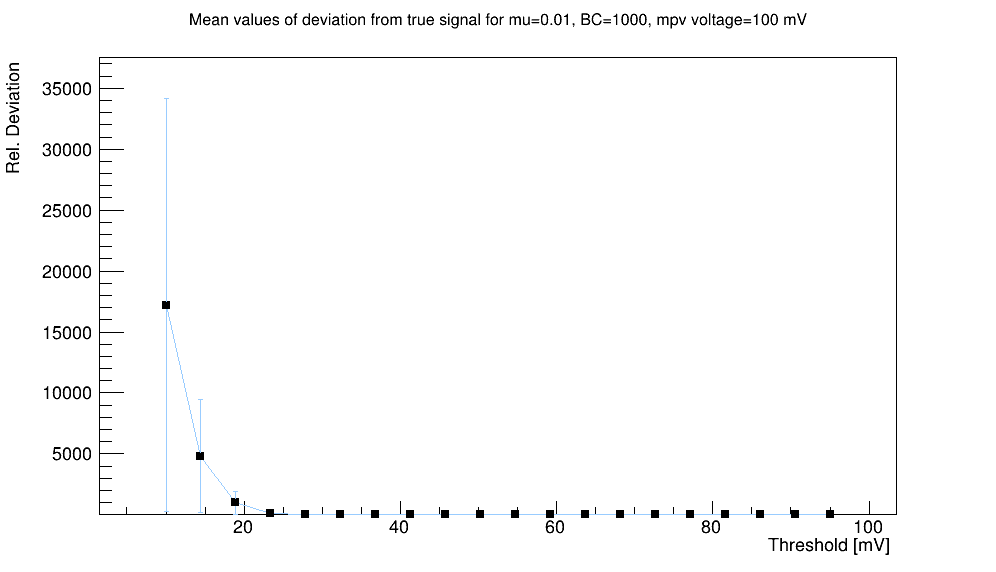

In [48]:
threshold_error = []
mean_rel = []
std_rel= []
mean_std_rel = []

#Calculate relative error for each array
for i in range (len(threshold_array)):
    threshold_error.append(0)
    #multiply by 100 to get relative error 
    std_rel.append(std_values[i]*100)
    mean_rel.append(mean_values[i]*100)
    mean_std_rel.append(mean_values_with_std[i]*100)

"""Standard deviation vs threshold plot"""

#create x,y values and corresponding errors

n = len(threshold_array);
x  = array( 'f', threshold_array )
ex = array( 'f', threshold_error)
y  = array( 'f', std_rel)
ey = array( 'f', threshold_error) 

std_graph = ROOT.TGraphErrors( n, x, y, ex, ey )

#create Canvas
c1 = ROOT.TCanvas("std over Threshold", "Difference in counts", 1000, 600)
#Set different plot settings 
std_graph.SetTitle("STD values from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Rel. Deviation; Z axis title" %(mu, bunch_crossings, peak_mpv_voltage))
std_graph.SetMarkerStyle(2)
std_graph.SetLineColor(ROOT.kAzure-9)
std_graph.SetFillColor(ROOT.kAzure-14)
std_graph.Draw()

#Draw and export final Histo
#c1.SetLogy()
c1.Draw()

"""Mean value vs threshold plot"""

y  = array( 'f', mean_rel)
ey = array( 'f', std_rel) 

deviation_graph = ROOT.TGraphErrors( n, x, y, ex, ey )

#create Canvas
c2 = ROOT.TCanvas("mean canvas", "", 1000, 600)
#Set different plot settings 
deviation_graph.SetTitle("Mean value of deviation from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Rel. Deviation; Z axis title" %(mu, bunch_crossings, peak_mpv_voltage))
deviation_graph.SetMarkerStyle(21)
deviation_graph.SetLineColor(ROOT.kAzure-9)
deviation_graph.SetFillColor(ROOT.kAzure-14)
deviation_graph.Draw()

#Draw and export final Histo
c2.SetLogy()
c2.Draw()

"""Mean+std vs threshold plot"""

y  = array( 'f', mean_std_rel)
ey = array( 'f', std_rel) 

mean_std_graph = ROOT.TGraphErrors( n, x, y, ex, ey )

#create Canvas
c3 = ROOT.TCanvas("mean_std", "Difference in counts", 1000, 600)
#Set different plot settings 
mean_std_graph.SetTitle("Mean values of deviation from true signal for mu=%.2f, BC=%d, mpv voltage=%d mV;Threshold [mV];Rel. Deviation; Z axis title" %(mu, bunch_crossings, peak_mpv_voltage))
mean_std_graph.SetMarkerStyle(21)
mean_std_graph.SetLineColor(ROOT.kAzure-9)
mean_std_graph.SetFillColor(ROOT.kAzure-14)
mean_std_graph.Draw()

#Draw and export final Histo
#c3.SetLogy()
c3.Draw()

### Study how the threshold and the deviation changes with worsening of the sensor with time because of radiation damage


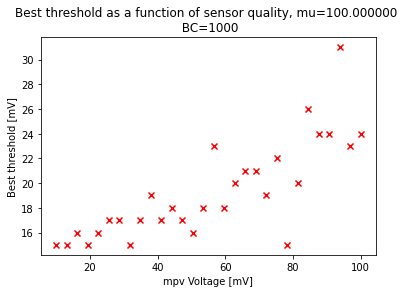

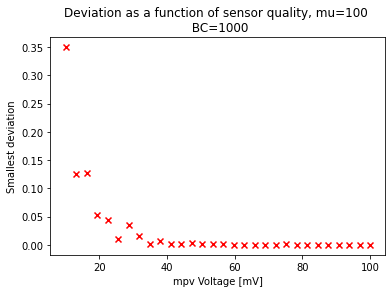

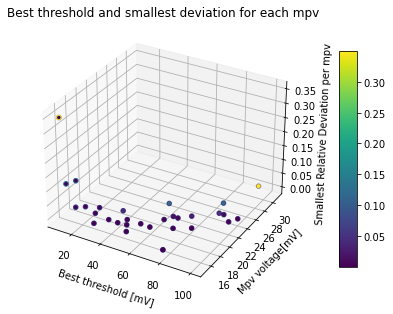

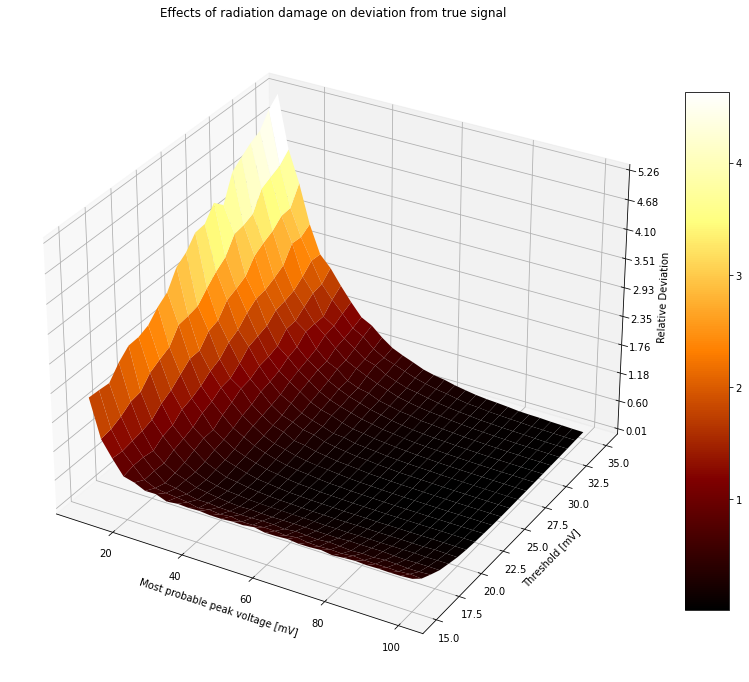

In [28]:
plt.scatter(mpv_peak_array, best_threshold_array, marker = "x", color='red')
plt.title("Best threshold as a function of sensor quality, mu=%f \n BC=%d" %(mu, bunch_crossings))
plt.xlabel("mpv Voltage [mV]")
plt.ylabel("Best threshold [mV]")
plt.show()

plt.scatter(mpv_peak_array, min_deviation_array*100, marker = "x", color='red')
plt.title("Deviation as a function of sensor quality, mu=%.f \n BC=%d" %(mu, bunch_crossings))
plt.xlabel("mpv Voltage [mV]")
plt.ylabel("Smallest deviation")
plt.show()


"""3D scatter plot with best thresholds and minimal deviation for that threshold"""
x = mpv_peak_array
y = best_threshold_array
z = min_deviation_array*100
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y ,z)
pnt3d=ax.scatter(x,y,z,c=z)
ax.set_title('Best threshold and smallest deviation for each mpv')
ax.set_zlabel('Smallest Relative Deviation per mpv')
ax.set_xlabel('Best threshold [mV]')
ax.set_ylabel('Mpv voltage[mV]')
# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([1, 0.2, 0.05, 0.6]) 
c = plt.colorbar(pnt3d, cax = cbaxes) 
plt.show()


"""3D plot of deviation as a function of mpv and threshold"""
x = mpv_peak_array
y = threshold_array
z = np.array(mpv_and_deviation)*100

xv, yv = np.meshgrid(x, y)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plot3d=ax.plot_surface(xv,yv,z,cmap='afmhot',)
ax.set_title('Effects of radiation damage on deviation from true signal')
ax.set_zlabel('Relative Deviation')
ax.set_xlabel('Most probable peak voltage [mV]')
ax.set_ylabel('Threshold [mV]')
# Customize the z axis.
#ax.set_zlim(0, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.92, 0.2, 0.05, 0.6]) 
cb = plt.colorbar(plot3d, cax = cbaxes)  
plt.show()




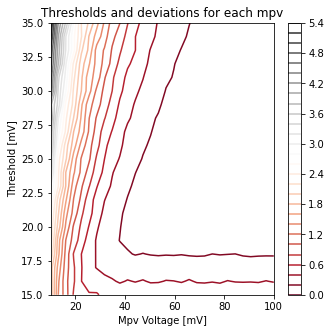

In [26]:
fig = plt.figure(figsize=(5,5))
plt.contour(x, y, z, 30, cmap='RdGy');
plt.title("Thresholds and deviations for each mpv")
plt.xlabel("Mpv Voltage [mV]")
plt.ylabel("Threshold [mV]")
plt.colorbar();

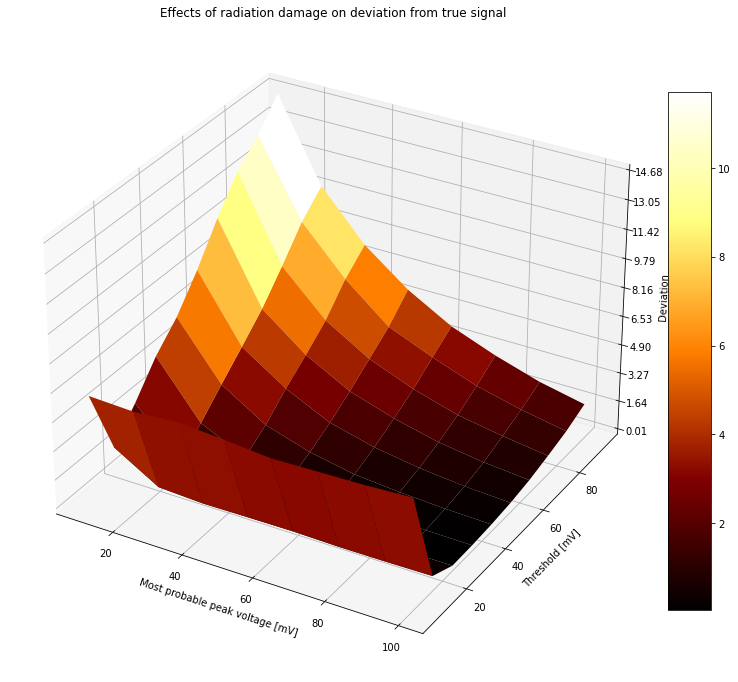

In [13]:
x = mpv_peak_array
y = threshold_array
z = np.array(mpv_and_deviation)*100

xv, yv = np.meshgrid(x, y)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
plot3d=ax.plot_surface(xv,yv,z,cmap='afmhot',)
ax.set_title('Effects of radiation damage on deviation from true signal')
ax.set_zlabel('Deviation')
ax.set_xlabel('Most probable peak voltage [mV]')
ax.set_ylabel('Threshold [mV]')
# Customize the z axis.
#ax.set_zlim(0, 0.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
cbaxes = fig.add_axes([0.9, 0.2, 0.05, 0.6]) 
cb = plt.colorbar(plot3d, cax = cbaxes)  
plt.show()

snr = 20 in the beginning

snr = 5 later 

large time window multiple of 3.125

todo later: check non-linear approximation of nr of particles vs mu 

